# Table of Contents
0. Initialization
1. Photometric Params
     * [Effective Radii Rn](#rnandn)
     * [The 'Spiking' Problem](#spiking)
     * [Sérsic Index n](#sersicindex)
2. Morphometric Params
    * [Concentrations $C_1$ and $C_2$](#cs)
    * [Asymmetries $A_1$ and $A_3$](#asymmetries)
    * [Smoothess $S_1$ and $S_3$](#smoothness)
    * [Gini and Entropy](#giniH)
    * [Spirality $\sigma_{\psi}$](#sigmapsi)
    * [$M_{20}$](#m20)
3. [LDA](#lda)
4. [Classification](#classification)
4. Appendixes    
    * [Catalog Class](#appclass)
    * [Plotting Utilities](#appB)

### If you are just reading this notebook skip **1. Initialization**

# 1. Initialization

Imports and autoreload

In [19]:
import logging
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import matthews_corrcoef
logger = logging.getLogger()
assert len(logger.handlers) == 1
handler = logger.handlers[0]
handler.setLevel(logging.INFO)

%matplotlib inline
%reload_ext autoreload
%autoreload 2
from __future__ import division
import sys
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
sys.path.append('/data/mfmtk-utils/')
from mfmtkutils import *

Setting up Paths, Redshift Steps and Class Information

In [2]:
path = '/data/catalogs/FERENGI/flux/'


redshifts = ['0.02', '0.03', '0.04', '0.05', '0.06', '0.07', '0.08', '0.09', '0.10', '0.12', 
             '0.14', '0.16', '0.18', '0.20', '0.25', '0.30', '0.35', '0.40', '0.45']

z = np.array(redshifts).astype(float)

T_type = np.loadtxt('/data/data_tables/EFIGI_attributes.txt', usecols=[0, 1, 2, 3], dtype=str).T

Which parameters do we need? (in order)

In [3]:
photo_params = ['Mo', 'RnFit2D', 'nFit2D', 'Rp']
morpho_params = ['C1', 'C2', 'A1', 'A3', 'S1', 'S3',
                 'G', 'H', 'M20', 'sigma_psi']

Load a catalog for each redshift. We are using the **mfmtkutils.catalog** class

In [4]:
flux_cats = []
for z in redshifts:
    cat = catalog(path=path+z+'.mfmtk')
    flux_cats.append(cat)

Now we can reduce flux_cats to produce catalogs for each parameter, let's start with the photo ones

In [5]:
photo_catalogs = []
for j, param in enumerate(photo_params):
    flux = flux_cats[0].reduce(flux_cats, param).raw_catalog
    photo_catalogs.append(flux[1:].astype(float))
    
galaxies = flux_cats[0].raw_catalog[0]

And the same for morpho ones

In [6]:
morpho_catalogs = []
for j, param in enumerate(morpho_params):
    flux = flux_cats[0].reduce(flux_cats, param).raw_catalog
    morpho_catalogs.append(flux[1:])

Label galaxies with types from EFIGI classification

In [10]:
E_indexes = T_type.T[np.where(T_type[1].astype(float) < -2)].T[0]
S_indexes = T_type.T[np.where((T_type[1].astype(float) >= 1) & (T_type[1].astype(float) < 7))].T[0]

spirals = np.array([i for i, val in enumerate(galaxies) if val in set(S_indexes)])
ellipticals = np.array([i for i, val in enumerate(galaxies) if val in set(E_indexes)])

print '# Spirals:', spirals.shape[0]
print '# Ellipticals:', ellipticals.shape[0]

# Spirals: 2091
# Ellipticals: 442


For example, let's work with the image size as an example. We can get all size information ($\rm Mo$) by calling

In [12]:
size = photo_catalogs[0].T

We can also check how the distribution changes with $z$ using the **mfmtkutils.plot_as_gaussians** function

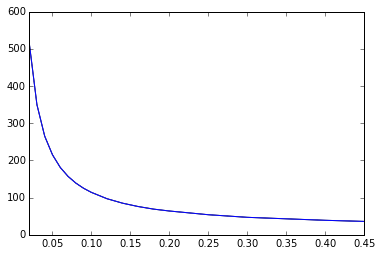

In [30]:
plot_as_gaussians(size, z)

Which is what we'd expect as all galaxies have the same image size for each redshift step.

# Photometric Params

**Morfometryka** fits both 1D and 2D sérsic profiles to each galaxy image giving us several photometric parameters to work with. For now, we're only concerned with the effective radii $R_n$ and the sérsic index $n$. 

## Effective Radii $R_n$

<div id="rnandn"></div>
Now, let's work with the Effective Radii (RnFit2D)

In [31]:
Rn = photo_catalogs[1].T.astype(float)

We can, for example, work with classes separately using the indexes from ''spirals'' and ''ellipticals'' as

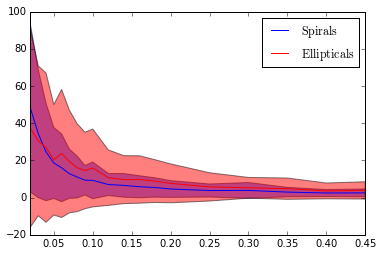

In [45]:
f, ax = plt.subplots(1, 1)
plot_as_gaussians(Rn[spirals], z, ax=ax, label=r'$\rm Spirals$')
plot_as_gaussians(Rn[ellipticals], z, ax=ax, color='red', label=r'$\rm Ellipticals$')
plt.legend(loc=1);

Solid lines shows means for each class and filled area shows $\pm 1\ \sigma$ fitted from a gaussian for each redshift. As we can see, the distributions follows the decreasing of the image resolution for obvious reasons. It is possible to recover the true value of $R_n$ by dividing it by the scale factor. We know that all images had $1024 \ x \ 1024 \ \rm pix^2$ prior the redshift simulations. So, recovering it is straightforward

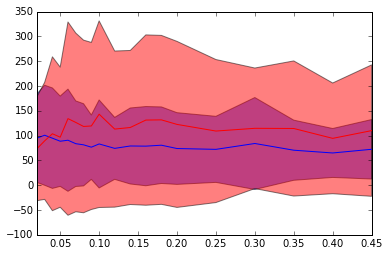

In [41]:
scale = 1024/size
Rn_correct = scale * Rn
f, ax = plt.subplots(1, 1)
plot_as_gaussians(Rn_correct[spirals], z, ax=ax)
plot_as_gaussians(Rn_correct[ellipticals], z, ax=ax, color='red')

The scattering in the ellipticals distribution is strange. Let's check that

<div id="spiking"></div>
# Spiking Effect (Sérsic 2D fit errors)

What is the overall behavior of $R_n$?

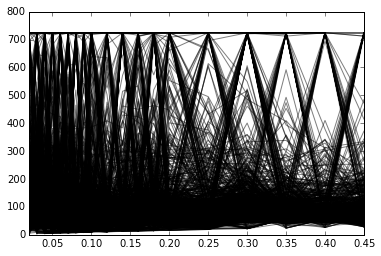

In [57]:
plt.plot(z, Rn_correct.T, '-k', alpha=0.5);
plt.xlim([z.min(), z.max()]);

This plot reveals some degree of error in our measurements. There is a spiking in some redshift slices due to Sérsic profile fitting errors, tracking those galaxies would be useful. We could do that by taking the derivative of our measurements and finding where there is a increase in the function since it is overall monotonic decreasing. Sure we would lose some information about ''natural'' increasing not due measurement erros, but in a whole this method works. We take the derivative for each galaxy and find which one has increasing regions (see **find_spiked** function in mfmtk-utils)

In [82]:
spiked, not_spiked = find_spiked(Rn, 1)

And then we have it

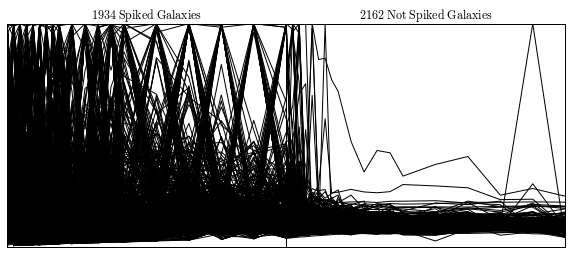

In [77]:
f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 4))
plt.subplots_adjust(wspace=0)
plt.xlim([z.min(), z.max()])
plt.xticks([])
plt.yticks([])
ax1.set_title(r'$' + str(np.size(spiked)) + '$' + r'$ \ \rm Spiked \ Galaxies$')
ax2.set_title(r'$' + str(np.size(not_spiked)) + '$' + r'$ \ \rm Not \ Spiked \ Galaxies$')
ax1.plot(z, Rn_correct[spiked].T, '-k')
ax2.plot(z, Rn_correct[not_spiked].T, '-k');

Almost half our sample has errors in the 2D sérsic fitting. Our objective is not to exclude these galaxies but to track them down and verify morfometryka's measurement on them. **galaxies[spiked]** give us every one of them but we would want only worst cases for it is a lot more easier to find the problem with them. We increase the threshold for 10 spikes so only galaxies showing 10 spikes are allowed in our selection

In [96]:
spiked, not_spiked = find_spiked(Rn, 10)
galaxies[spiked].tolist()

['PGC0027041',
 'PGC0031003',
 'PGC0034004',
 'PGC0046819',
 'PGC0047709',
 'PGC0056617',
 'PGC0057634',
 'PGC0059647',
 'PGC0060049']

We reduced our pool of galaxies from $\sim 2000$ to $9$. Let's write them in a catalog for future use

In [89]:
f = open('/data/worst_spiking_cases.mfmtk', 'w')
for gal in galaxies[spiked]:
    f.write(gal + '\n')
f.close()

## Sérsic Index $n$

<div id="sersicindex"></div>
Let's proceed to the Sérsic Index.

In [104]:
n = photo_catalogs[2].T.astype(float)

Since $n$ is also a Sérsic Profile parameter, we expect to find the same errors as $R_n$. Let's find spiked galaxies for $n$. In general, they must be the same galaxies that had spikes in $R_n$, but as $n$ and $R_n$ have two completely different behaviors ($n$ does not explicitly depends on resolution, for example) the idea is to find the spiked ones again.

In [220]:
spiked, not_spiked = find_spiked(n, 2)

NameError: name 'n' is not defined

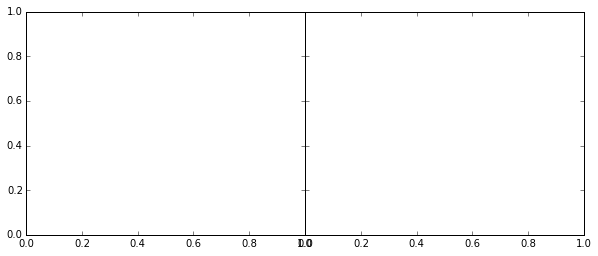

In [11]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 4))
plt.subplots_adjust(wspace=0)
plot_as_gaussians(n[spirals], z, ax1, ylabel=r'$\rm Sersic \ Index$', title=r'$ \rm All \ Galaxies$')
plot_as_gaussians(n[ellipticals], z, ax1, color='Red')
plot_as_gaussians(n[intersect(spirals, not_spiked)], z, ax2, title=r'$ \rm Not \ Spiked \ Galaxies$')
plot_as_gaussians(n[intersect(ellipticals, not_spiked)], z, ax2, color='Red')

Our sample without spiked galaxies shows a huge difference from all the sample. Prior making any assumptions in both $R_n$ and $n$ we must check these errors. 

# Morphometric Parameters

Morphometric morphology is an alias to non-parametric morphology. It does not depend on profiles nor models and with that in mind we can proceed to analize our morphometric parameters without worryng about the errors found in the profile fitting. 

<div id="cs"></div>
## Concentrations $C_1$ and $C_2$

Concentrations measure the ratio between an outer radius and an inner radius. They are found by selecting %'s of light that each one have within it, giving us a measure of concentration. We usually use

$$ C_1 = \log_{10} \left ( \frac{R_{80}}{R_{20}} \right ) $$ $$ C_2 = \log_{10} \left ( \frac{R_{90}}{R_{50}} \right ) $$

As a concentration measurement, they also correlate with $n$. [see **Andrae et al. 2011**]

In [14]:
C1 = morpho_catalogs[0].astype(float).T/5
C2 = morpho_catalogs[1].astype(float).T/5
z  = np.array(redshifts).astype(float)

Distributions for $C_1$ and $C_2$ are

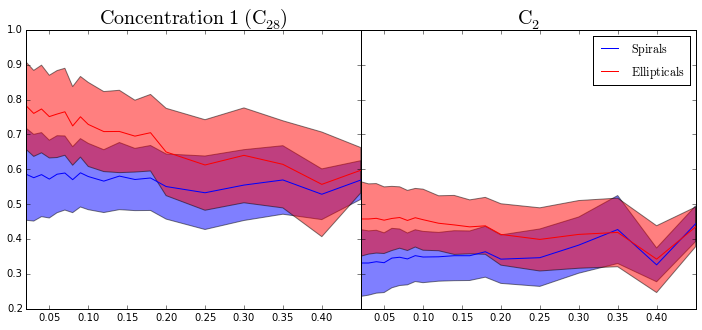

In [28]:
f, (ax1, ax2) = plt.subplots(1,2, sharey=True, sharex=True, figsize=(12, 5))
plt.subplots_adjust(wspace=0)
ax1.set_xlim([0.02, 0.45])
plot_as_gaussians(C1[spirals], z, ax1, title=r'$ \rm C_1 $')
plot_as_gaussians(C1[ellipticals], z, ax1, color='red')
plot_as_gaussians(C2[spirals], z, ax2, title=r'$\rm C_2$', label=r'$\rm Spirals$')
plot_as_gaussians(C2[ellipticals], z, ax2, label=r'$\rm Ellipticals$', color='red')
adjust_ticks(ax1)
plt.legend(loc=1);

The $C_1$ distributions for each redshift are

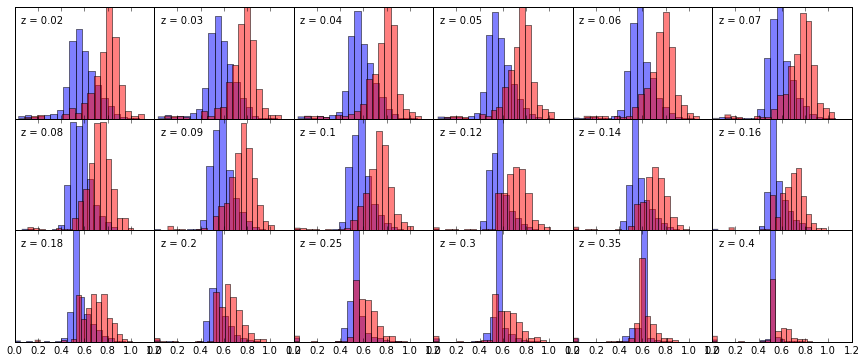

In [164]:
f, axes = plt.subplots(3, 6, sharex=True, figsize=(15, 6))
plt.subplots_adjust(wspace=0, hspace=0)
histograms(C1[spirals], z, axes, normed=1)
histograms(C1[ellipticals], z, axes, color='red', normed=1, xinfo=True)

the same for $C_2$ gives

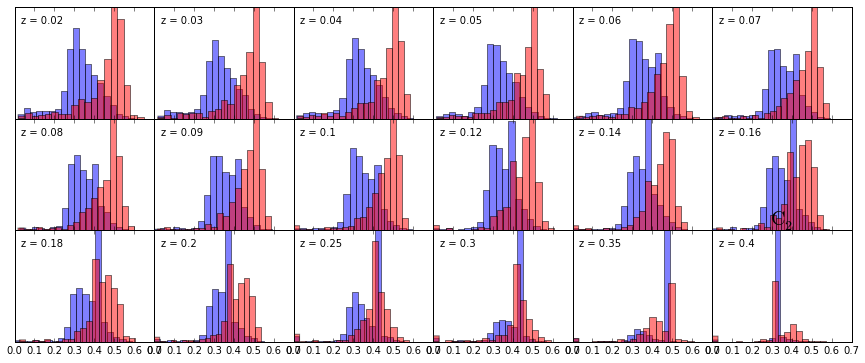

In [166]:
f, axes = plt.subplots(3, 6, sharex=True, figsize=(15, 6))
plt.subplots_adjust(wspace=0, hspace=0)
histograms(C2[spirals], z, axes, normed=1)
histograms(C2[ellipticals], z, axes, color='red', normed=1, xinfo=True)

<div id='asymmetries'></div>
## Asymmetries $A_1$ and $A_3$

In [29]:
A1 = morpho_catalogs[2].astype(float).T
A3 = morpho_catalogs[3].astype(float).T

Distributions for $A_1$ and $A_3$ are

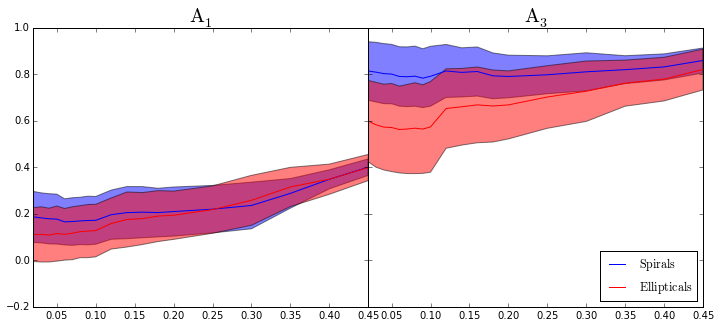

In [30]:
f, (ax1, ax2) = plt.subplots(1,2, sharey=True, sharex=True, figsize=(12, 5))
plt.subplots_adjust(wspace=0)
ax1.set_xlim([0.02, 0.45])
plot_as_gaussians(A1[spirals], z, ax1, title=r'$\rm A_1$')
plot_as_gaussians(A1[ellipticals], z, ax1, color='red')
plot_as_gaussians(A3[spirals], z, ax2, title=r'$\rm A_3$', label=r'$\rm Spirals$')
plot_as_gaussians(A3[ellipticals], z, ax2, label=r'$\rm Ellipticals$', color='red')
plt.legend(loc=4);

Histograms for $A_1$

NameError: name 'A1' is not defined

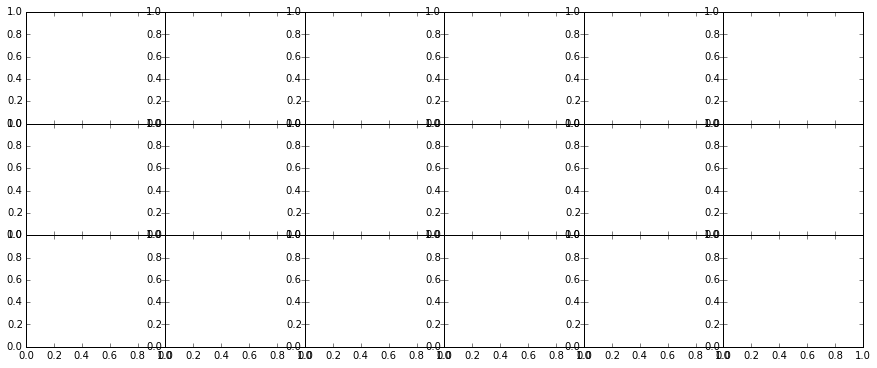

In [27]:
f, axes = plt.subplots(3, 6, sharex=True, figsize=(15, 6))
plt.subplots_adjust(wspace=0, hspace=0)
histograms(A1[spirals], z, axes, normed=1)
histograms(A1[ellipticals], z, axes, color='red', normed=1, xinfo=True)

Histograms for $A_3$

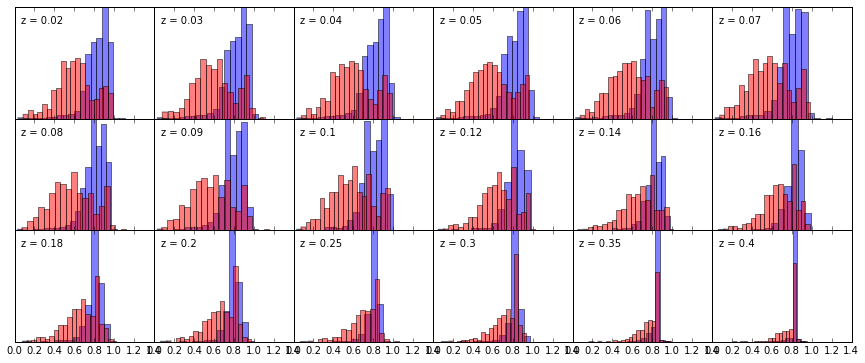

In [173]:
f, axes = plt.subplots(3, 6, sharex=True, figsize=(15, 6))
plt.subplots_adjust(wspace=0, hspace=0)
histograms(A3[spirals], z, axes, normed=1)
histograms(A3[ellipticals], z, axes, color='red', normed=1, xinfo=True)

<div id='smoothness'></div>
## Smoothness $S_1$ and $S_3$

In [195]:
S1 = morpho_catalogs[4].astype(float).T
S3 = morpho_catalogs[5].astype(float).T

Distributions for $S_1$ and $S_3$ are

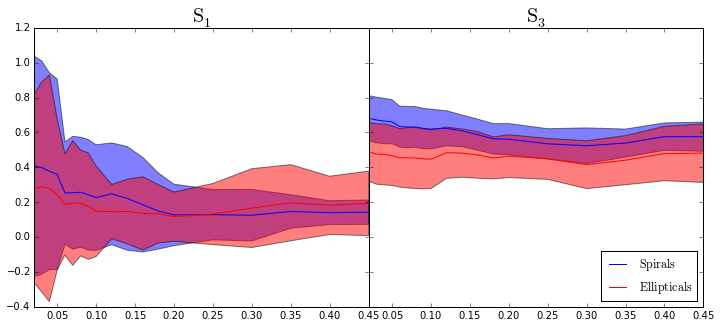

In [184]:
f, (ax1, ax2) = plt.subplots(1,2, sharey=True, sharex=True, figsize=(12, 5))
plt.subplots_adjust(wspace=0)
ax1.set_xlim([0.02, 0.45])
plot_as_gaussians(S1[spirals], z, ax1, title=r'$\rm S_1$')
plot_as_gaussians(S1[ellipticals], z, ax1, color='red')
plot_as_gaussians(S3[spirals], z, ax2, title=r'$\rm S_3$', label=r'$\rm Spirals$')
plot_as_gaussians(S3[ellipticals], z, ax2, label=r'$\rm Ellipticals$', color='red')
plt.legend(loc=4);

Histograms for $S_1$

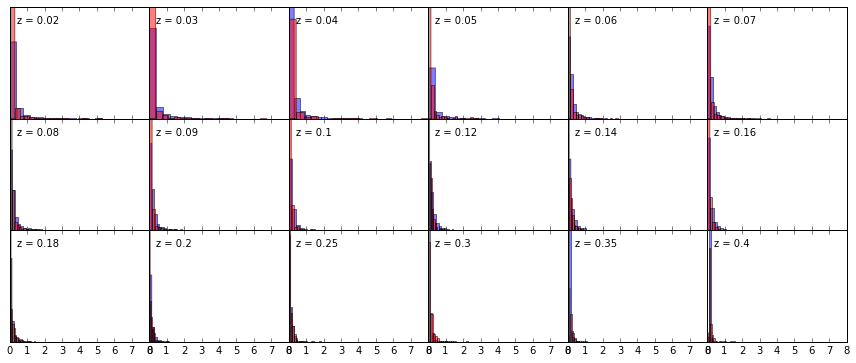

In [185]:
f, axes = plt.subplots(3, 6, sharex=True, figsize=(15, 6))
plt.subplots_adjust(wspace=0, hspace=0)
histograms(S1[spirals], z, axes, normed=1)
histograms(S1[ellipticals], z, axes, color='red', normed=1, xinfo=True)

Histograms for $S_3$

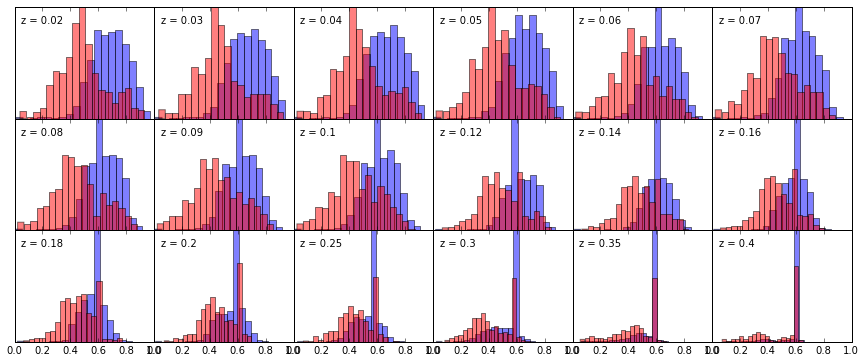

In [186]:
f, axes = plt.subplots(3, 6, sharex=True, figsize=(15, 6))
plt.subplots_adjust(wspace=0, hspace=0)
histograms(S3[spirals], z, axes, normed=1)
histograms(S3[ellipticals], z, axes, color='red', normed=1, xinfo=True)

<div id='giniH'></div>
## Gini $G$ and Entropy $H$

In [31]:
G = morpho_catalogs[6].astype(float).T
H = morpho_catalogs[7].astype(float).T
print G[ellipticals]

[[ 0.83295  0.81436  0.81452 ...,  0.74216  0.73969  0.70399]
 [ 0.77042  0.77171  0.76308 ...,  0.68443  0.73969  0.70399]
 [ 0.77623  0.77103  0.77095 ...,  0.68853  0.73969  0.70399]
 ..., 
 [ 0.77345  0.77355  0.77349 ...,  0.69223  0.68947  0.70399]
 [ 0.72645  0.73203  0.71657 ...,  0.75179  0.74444  0.70399]
 [ 0.75732  0.74104  0.7406  ...,  0.70522  0.72541  0.71919]]


Gini $G$ and entropy $H$ distribution

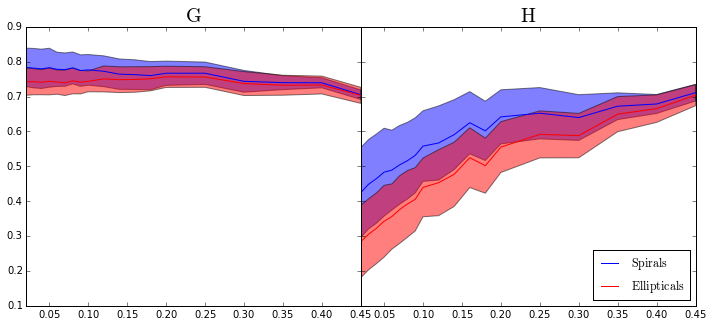

In [32]:
f, (ax1, ax2) = plt.subplots(1,2, sharey=True, sharex=True, figsize=(12, 5))
plt.subplots_adjust(wspace=0)
ax1.set_xlim([0.02, 0.45])
plot_as_gaussians(G[spirals], z, ax1, title=r'$\rm G$')
plot_as_gaussians(G[ellipticals], z, ax1, color='red')
plot_as_gaussians(H[spirals], z, ax2, title=r'$\rm H$', label=r'$\rm Spirals$')
plot_as_gaussians(H[ellipticals], z, ax2, label=r'$\rm Ellipticals$', color='red')
plt.legend(loc=4);

Histograms for $G$

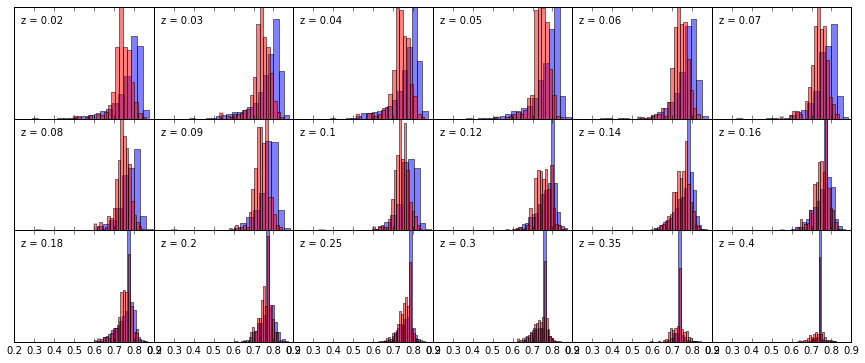

In [196]:
f, axes = plt.subplots(3, 6, sharex=True, figsize=(15, 6))
plt.subplots_adjust(wspace=0, hspace=0)
histograms(G[spirals], z, axes, normed=1)
histograms(G[ellipticals], z, axes, color='red', normed=1, xinfo=True)

Histograms for $H$

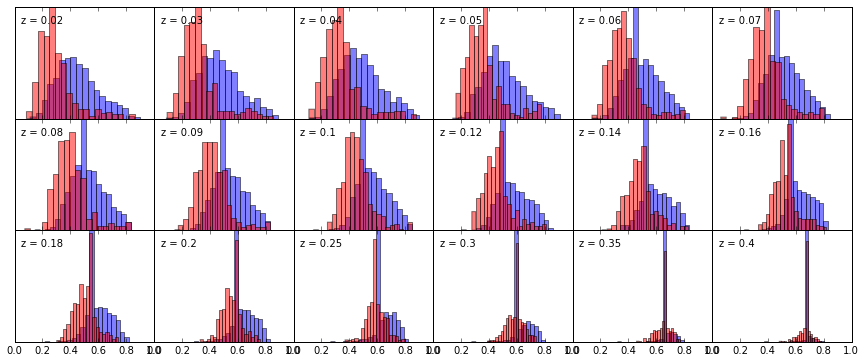

In [197]:
f, axes = plt.subplots(3, 6, sharex=True, figsize=(15, 6))
plt.subplots_adjust(wspace=0, hspace=0)
histograms(H[spirals], z, axes, normed=1)
histograms(H[ellipticals], z, axes, color='red', normed=1, xinfo=True)

<div id="sigmapsi"></div>
# Spirality $\sigma_\psi$

In [90]:
spsi = ma.array(morpho_catalogs[9].astype(float).T)
print np.where(np.isnan(spsi))[0]
print spsi.shape

spsi[np.where(np.isnan(spsi) == True)] = 0

[ 232  251  266  266  312  312  312  319  319  319  332  332  365  365  365
  365  365  365  470  475  475  548  548  548  559  559  559  559  559  559
  559  559  559  559  559  559  559  618  675  675  712  760  804  804  818
  818  818  818  818  882  882  891  891  891 1030 1101 1223 1647 1692 1982
 2130 2258 2350 2350 2350 2480 2918 2936 2936 2936 2936 2936 2936 2936 2936
 2936 2975 2975 3322 3403 3544 3574 3574 3574 3574 3574 3642 3642 3642 3642
 3689 3689 3689 3689 3689 3689 3689 3689 3689 3689 3740 3740 3740 3740 3740
 3753 3753 3753 3773 3773 3798 3798 3889 3889 3945 3989 3989 3989 3989 3989
 4015 4015 4015 4023 4023 4023 4023 4047 4082 4082 4082 4082 4082 4082 4082
 4082]
(4161, 19)


$\sigma_{\psi}$ distributions

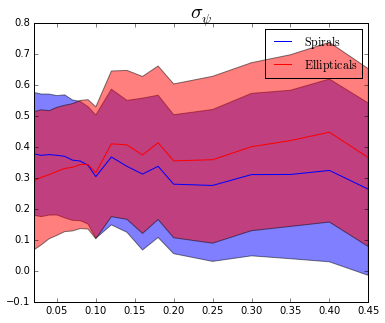

In [91]:
f, ax2 = plt.subplots(1,1, figsize=(6, 5))
plt.subplots_adjust(wspace=0)
ax2.set_xlim([0.02, 0.45])
plot_as_gaussians(spsi[spirals], z, ax2, title=r'$\rm \sigma_{\psi}$', label=r'$\rm Spirals$')
plot_as_gaussians(spsi[ellipticals], z, ax2, label=r'$\rm Ellipticals$', color='red')
plt.legend(loc=1);

Histograms

In [ ]:
f, axes = plt.subplots(3, 6, sharex=True, figsize=(15, 6))
plt.subplots_adjust(wspace=0, hspace=0)
histograms(spsi[spirals], z, axes, normed=1)
histograms(spsi[ellipticals], z, axes, color='red', normed=1)

<div id='m20'></div>
## $\rm M_{20}$

In [22]:
M20 = morpho_catalogs[8].astype(float).T

$M_{20}$ distribution is

In [ ]:
f, ax2 = plt.subplots(1,1, figsize=(6, 5))
plt.subplots_adjust(wspace=0)
ax2.set_xlim([0.02, 0.45])
plot_as_gaussians(M20[spirals], z, ax2, title=r'$\rm M_{20}$', label=r'$\rm Spirals$')
plot_as_gaussians(M20[ellipticals], z, ax2, label=r'$\rm Ellipticals$', color='red')
plt.legend(loc=4);

# 4. LDA - Linear Discriminant Analysis
## 4.1 Fisher's Discriminant

Here, I am following the step-by-step guide for LDA available from [Raschka](http://sebastianraschka.com/Articles/2014_python_lda.html) website but adapted to our problem of two major galaxy morphological classes. We are going to performe LDA in $z = 0.02$ first.

In [3]:
data = catalog(path='/data/catalogs/1024_r.mfmtk')
params = ['C1', 'A3', 'S3', 'H', 'sigma_psi']
galaxies = data.raw_catalog[0]

classes = classes_indexes(galaxies, T_type)
data = data.param_selection(params)

$C_1$ is not in the correct range, we need to divide it by 5

In [4]:
data.T[0] = data.T[0]/5

So we have a NxM matrix where N is the numbers of features and M the total number of galaxies in our sample

In [7]:
N = data.shape[1]

## Step 0: Feature Selection

The feature selection was already made by [Ferrari et al. 2015](http://arxiv.org/abs/1509.05430) for our set of parameters so I am skipping this step, using

$$\textbf{x}  = \{ C_1, A_3, S_3, H, \sigma_{\psi} \}$$

this particular feature selection agrees with the histograms in previous sections. The only thing to note is that $\sigma_{\psi}$seems to be worse here than in the graph showed in the paper.

## Step 1: Computing the d-dimensional mean vectors

We have to compute the mean vector $m_i$, $(i = 1, 2)$ for both classes. 

In [8]:
mean_vectors = []
for c in classes:
    mean_vectors.append(np.mean(data[c], axis=0))
mean_vectors

[array([ 0.57467039,  0.85963314,  0.71788524,  0.45453253,  0.44731795]),
 array([ 0.77090374,  0.7435191 ,  0.57318796,  0.27739987,  0.27900823])]

## Step 2: Computing the Scatter Matrices

### 2.1 Within-class scatter matrix $S_W$

The within-class scatter matrix $S_W$ follow: $$S_W = \sum^{\rm classe}_{i=1} S_i $$ where $$ S_i = \sum_{x}^{n} (\textbf{x} - \textbf{m_i})(\textbf{x} - \textbf{m_i})^T$$
where $\textbf{x}$ is our data and $m_i$ the mean vector for $i$th class.

In [11]:
SW = np.zeros(())
for c in classes:
    SW_temp = np.zeros((N,N))
    for galaxy in data[c]:
        galaxy, mv = galaxy.reshape(N, 1), mean_vectors[0].reshape(N,1)
        SW_temp += (galaxy-mv).dot((galaxy-mv).T)
    SW = SW + SW_temp

### 2.2 Between-class scatter matrix $S_B$

The between-class scatter matrix $S_B$ can be found by
$$ S_B = \sum_{i=1}^{\rm class} N_i ( \mathbf{m_i} - \mathbf{m} ) (\mathbf{m_i} - \mathbf{m})^T $$
where $\mathbf{m}$ is the overall mean, $\mathbf{m_i}$ is mean vector for $i$th class and $N_i$ is the sample size for given class.

In [10]:
overall_mean = np.mean(data, axis=0)
S_B = np.zeros((N,N))
for galclass, mv in zip(classes, mean_vectors):
    Ni = data[galclass].shape[0]
    mv = mv.reshape(N,1)
    overall_mean = overall_mean.reshape(N,1)
    S_B  += Ni* (mv - overall_mean).dot((mv-overall_mean).T)

## Step 3: Solving eigenvalue problem

With both matrix at hand $S_W$ and $S_B$ we can solve the eigenvalue problem for the matrix $S^{-1}_W S_B$

In [12]:
eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(SW).dot(S_B))

Now it is useful to sort our eigenvectors and eigenvalues

In [13]:
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
eig_pairs = sorted(eig_pairs, key=lambda k: k[0], reverse=True)

Now we can see the significance of each one of our pairs

In [14]:
eigv_sum = sum(eig_vals)
for i,j in enumerate(eig_pairs):
    print('eigenvalue {0:}: {1:.2%}'.format(i+1, (j[0]/eigv_sum).real))

eigenvalue 1: 100.00%
eigenvalue 2: 0.00%
eigenvalue 3: 0.00%
eigenvalue 4: 0.00%
eigenvalue 5: 0.00%


Only two of the eigenvalues give us important information about our system. We create our weight vector with the correspondent eigenvectors

In [15]:
W = np.hstack((eig_pairs[0][1].reshape(N,1), eig_pairs[1][1].reshape(N,1)))

Transform our data into our new space generated by the eigenvectors selected

In [16]:
X_lda = data.dot(W)

Let's plot the results to check it

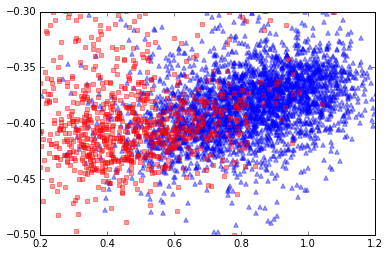

In [21]:
plt.xlim(0.2, 1.2)
plt.ylim(-0.5, -0.3)
for label, marker, color in zip(classes, ('^', 's'),('blue', 'red')):
       plt.scatter(x=X_lda[:,0].real[label],
                    y=X_lda[:,1].real[label],
                    marker=marker,
                    color=color,
                    alpha=0.4)

# 4.2 Bayesian Classifier
## Step 1. Covariance Matrixes

The fisher's process is only made for dimensionality reduction, we still do not have a hyperplane to separate the classes. To do that, we will use a Bayesian approach as described in **Ferrari et al. 2015**. The first step towards it is to find the covariance matrix. In the case of a LDA, we consider identical matrixes for each class. It can be found by

$$ \Sigma_i = \frac{1}{N_i - 1} \sum_{\mathbf{x}}^{N} (\mathbf{x} - \mathbf{m_i}) (\mathbf{x} - \mathbf{m_i})^T $$

Let's do that for the spirals

In [32]:
mean_vectors = []
for c in classes:
    mean_vectors.append(np.mean(X_lda.real[c], axis=0))
mean_vectors

SIGMA = np.zeros((2,2))
for galaxy in X_lda.real[classes[0]]:
    galaxy, mv = galaxy.reshape(2, 1), mean_vectors[0].reshape(2,1)
    SIGMA += (galaxy-mv).dot((galaxy-mv).T)
Ni = data[classes[0]].shape[0]
SIGMA = 1./(Ni - 1) * SIGMA
SIGMA

array([[ 0.03328066,  0.00033804],
       [ 0.00033804,  0.00301856]])

## Step 2. Prior Probabilities

To proceed with the Bayes approach to the classification, one must find the prior probability $P(C_i)$ for each $i$th class. This is usually done by finding the frequencies of occurrence of given class in the whole data, i.e, the probability of picking a galaxy of given class without any other information

$$ \pi_k = \frac{\# \rm \ galaxies \  in \ class \ k}{\# \ total \ number \ of \ galaxies}$$

In [33]:
Ntot = data.real[classes[0]].shape[0] + data.real[classes[1]].shape[0]
prior = []
for c in classes:
    prior.append(data.real[c].shape[0]/Ntot)
prior

[0.7728911319394376, 0.22710886806056235]

## Discriminant Function

Our discriminant function is a linear discriminant given by $$ f(\mathbf{x}) = \mathbf{w}^T \mathbf{x}  + w_0 $$ anf following **Ferrari el al. 2015**, assuming our likelihood function is a gaussian, we have
$$ \mathbf{w}  = \mathbf{\Sigma^{-1}} (\mathbf{\mu_1} - \mathbf{\mu_2)}$$ 
and the threshold $w_0$ is
$$ w_0 = \frac{1}{2} \mathbf{\mu_1}^{T} \mathbf{\Sigma}^{-1} \mathbf{\mu_1} + \frac{1}{2} \mathbf{\mu_2}^{T} \mathbf{\Sigma}^{-1} \mathbf{\mu_2} + \ln \frac{P(C_1)}{P(C_2)} $$

In [34]:
SIGMA_I = np.linalg.inv(SIGMA)
W = SIGMA_I.dot(mean_vectors[0] - mean_vectors[1])
w0 = np.log(prior[0]/prior[1]) - 0.5 * ((mean_vectors[0]).T.dot(SIGMA_I)).dot(mean_vectors[0]) + 0.5 * ((mean_vectors[1]).T.dot(SIGMA_I)).dot(mean_vectors[1])
W, w0

(array([ 10.63716087,  -1.19123024]), -6.0520202554854556)

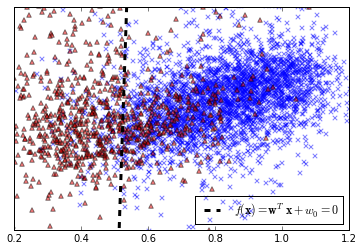

In [47]:
plot_2Ddiscriminant(X_lda, classes, W, w0)

<div id="classification"></div>
# 5. Morphology Classifier

Previous section show the basics about training the discriminant function. Now we're going to understand our classification scheme with more detail. We need to measure the performance of the classifier, use it in test data and try to visualize it. Now we are going to use the full 5D parameter space to do the classification. 

Using Ferrari's approach, using same features

In [33]:
params = ['C1', 'A3', 'S3', 'H', 'sigma_psi']

But now we want to use **Galaxy Zoo** classification information to train our discriminant. It has information if a galaxy is Spiral **S**, Elliptical **E** or if the classification is Uncertain **U**. 

zoo_info = np.loadtxt('/data/classifi2/EFIGI_sdss_mfmtk_ttype_zoo.csv',
                       delimiter=',', usecols=[15, 44], dtype=str).T

We need to load our data. Let's use the raw data of EFIGI, without any redshift simulations.

In [34]:
zoo_info = np.loadtxt('/data/classifi2/EFIGI_sdss_mfmtk_ttype_zoo.csv',
                       delimiter=',', usecols=[15, 44], dtype=str).T
data = catalog(path='/data/catalogs/1024_r.mfmtk')
galaxies = data.raw_catalog[0]
data = data.param_selection(params)
data[0] = data[0]/5 #C1

Now we use **mfmtkutils.classes_from_zoo** to label all galaxies in the EFIGI using Galaxy Zoo data

In [35]:
classes = classes_from_zoo(galaxies, zoo_info)

By default, classes_from_zoo sets the uncertain galaxies with 0, so we need to select only the valid ones

In [36]:
valids = np.where(classes > 0)    

As EFIGI has information about the **T Type** of each galaxy is useful to check the distribution of morphologies of our labeled sample. **mfmtkutils.EFIGI_ttype** gives the T Type distribution for given set of galaxies

In [37]:
ttypes = EFIGI_ttype(galaxies, T_type)

One can now compate the EFIGI morphological distribution and the valid zoo sample distribution

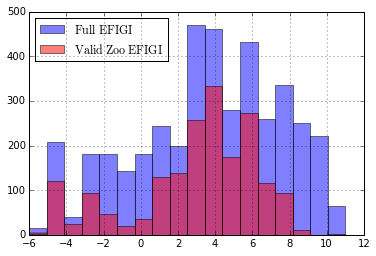

In [38]:
plt.grid()
plt.hist(ttypes, bins=18, alpha=0.5, label=r'$\rm Full \ EFIGI$');
plt.hist(ttypes[valids], bins=18, alpha=0.5, color='red',label=r'$\rm Valid \ Zoo \ EFIGI$');
plt.legend(loc=2)

The majority of losses are in the number of **Lenticulars** and **Irregulars**. As we want to make an E-S classification, our Valid Zoo sample represents the EFIGI sample very well, Ellipticals have $\rm T\ Type < -4$ and Spirals have $\rm  T \ Type > 0$ and $\rm  T \ Type < 8$.

Now we calculate the priors

In [39]:
NE = np.size(classes[np.where(classes == 2)])
NS = np.size(classes[np.where(classes == 1)])
priors = np.array([NS/(NE+NS), NE/(NE+NS)])
priors

array([ 0.84143086,  0.15856914])

And train our linear classifier

In [40]:
lda = LDA(solver='lsqr', priors=priors, store_covariance=1)
lda.fit(data[valids], classes[valids])

LinearDiscriminantAnalysis(n_components=None,
              priors=array([ 0.84143,  0.15857]), shrinkage=None,
              solver='lsqr', store_covariance=1, tol=0.0001)

And predict the Morphometric Index. Set logging level to a higher level if you don't want the output

In [41]:
logger.setLevel(30)
Mi = lda_report_normalize(lda, data[valids])

Our $M_i$ distribution is given then by

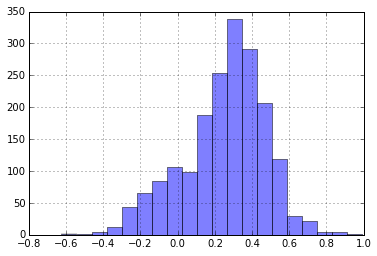

In [42]:
plt.hist(Mi, bins=20, alpha=0.5);
plt.grid()

If our classification is good, $M_i$ could correlate with $T Type$.

(-0.6, 1.1)

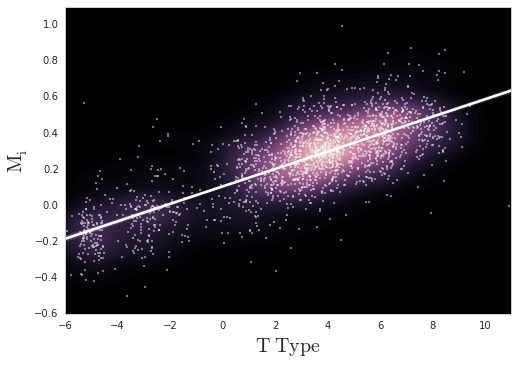

In [44]:
import seaborn as sns
sns.set_style("whitegrid")
cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=0.8, reverse=True)
sns.kdeplot(ttypes[valids], Mi,  x_jitter=0.5, cmap=cmap, shade=True, n_levels=60)
sns.regplot(x=ttypes[valids], y=Mi, color='white', x_jitter=0.5, scatter=True, scatter_kws={"s" : 5, "alpha" : 0.5})

plt.xlabel(r'$\rm T \ Type$', fontsize=20)
plt.ylabel(r'$\rm M_i$', fontsize=20);

plt.xlim(-6, 11)
plt.ylim(-0.6, 1.1)

Even showing a clearly remarkable correlation with T Type (Ferrari et al 2015), is useful to extract metrics to measure our classifier performance in our data. We use the function **avaliador** created by Ferrari that measures A, P, R and F1 via crossvalidation.

In [18]:
logger.setLevel(10)
(A, P, R, F1) = avaliador(lda, data[valids], classes[valids]);

INFO:root:A =  93.97%
INFO:root:P =  96.13%
INFO:root:R =  96.72%
INFO:root:F1=  96.39%


Another way of visualizating these metrics is with a confusion matrix

<matplotlib.colorbar.Colorbar instance at 0x7f3fc76465a8>

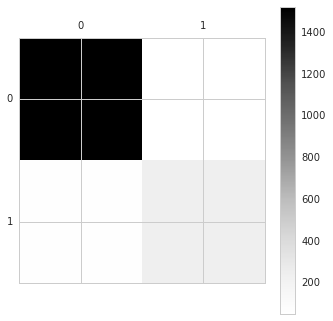

In [19]:
from sklearn.metrics import confusion_matrix
predictions = predict(lda, data[valids], classes[valids])
cm = confusion_matrix(classes[valids], predictions)
plt.matshow(cm)
plt.colorbar()

Unfortunetly these metrics can suffer from bias via class imbalance. In our sample we have almost six times the number of spirals than ellipticals

In [20]:
'Spirals to Ellipticals ratios: {:.1f}'.format(NS/NE)

'Spirals to Ellipticals ratios: 5.3'

Another metric that does not suffer from this type of bias is the **Matthews correlation coefficient** (MCC). From wikipédia:

> The Matthews correlation coefficient is used in machine learning as a measure of the quality of binary (two-class) classifications. It takes into account true and false positives and negatives and is generally regarded as a balanced measure which can be used even if the classes are of very different sizes. The MCC is in essence a correlation coefficient value between -1 and +1. A coefficient of +1 represents a perfect prediction, 0 an average random prediction and -1 an inverse prediction. The statistic is also known as the phi coefficient. [source: Wikipedia]



In [21]:
from sklearn.metrics import matthews_corrcoef as MCC
MCCc = MCC(classes[valids], predictions)
'MCC = {:.2f}'.format(MCCc)

'MCC = 0.77'

That is almost 10% lower than all the other metrics, so probabily it has something to do with our class imbalance since a classifier that predicts every galaxy as spiral in our sample would give us 80%~ for the ARPF1 metrics. But our MCC is high, almost 80%, it give us a pretty good classifier, even with this class imbalance. Another way of seeing our classifier's performance is by Receiver Operating Characteristic curves (ROC). Via wikipédia
>In statistics, a receiver operating characteristic (ROC), or ROC curve, is a graphical plot that illustrates the performance of a binary classifier system as its discrimination threshold is varied. The curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings. The true-positive rate is also known as sensitivity, or recall in machine learning. The false-positive rate is also known as the fall-out and can be calculated as (1 - specificity). The ROC curve is thus the sensitivity as a function of fall-out. In general, if the probability distributions for both detection and false alarm are known, the ROC curve can be generated by plotting the cumulative distribution function (area under the probability distribution from $-\infty$ to $+\infty$) of the detection probability in the y-axis versus the cumulative distribution function of the false-alarm probability in x-axis.



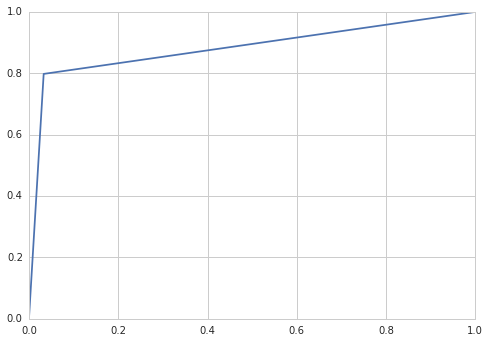

In [22]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
fpr, tpr, thresholds = roc_curve(classes[valids], predictions, pos_label=2)
plt.plot(fpr, tpr);

And the useful information from this curve is the area under it. If Area = 10, we have a perfect classifier while 0.5 means a random classifier and -1 a inverse one. It is analogous to the MCC.

In [24]:
AUC = roc_auc_score(classes[valids]-1, predictions-1)
'AUC = {:.2f}'.format(AUC)

'AUC = 0.88'

We can summarize all our metrics as follows

In [25]:
print('A = {:1.2f}%'.format(A*100))
print('P = {:1.2f}%'.format(P*100))
print('R = {:1.2f}%'.format(R*100))
print('F1 = {:1.2f}%'.format(F1*100))
print('MCC = {:1.2f}'.format(MCCc))
print('AUC = {:1.2f}'.format(AUC))

A = 93.97%
P = 96.13%
R = 96.72%
F1 = 96.39%
MCC = 0.77
AUC = 0.88


Now we can do this very same procedure for each redshift simulation step and see how these metrics changes over $z$.

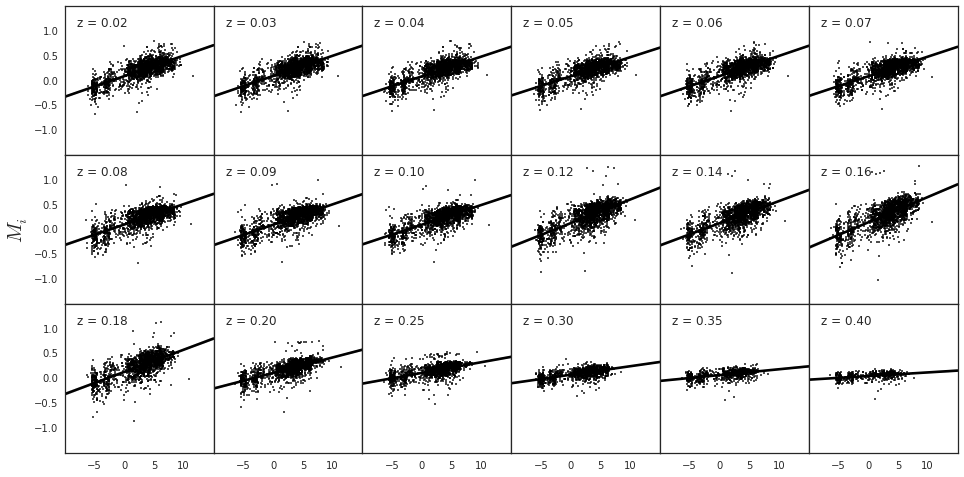

In [66]:
import seaborn as sns
logger.setLevel(30)

params = ['C1', 'A3', 'S3', 'H', 'sigma_psi']
sns.set_style("white")
    
MCCs  = []
AUCs  = []
As    = []
Ps    = []
Rs    = []
F1s   = []
fits = np.array([np.zeros(2)]).reshape(2,1)
f, axes = plt.subplots(3, 6, sharex=True, sharey=True, figsize=(16, 8))
plt.subplots_adjust(wspace=0, hspace=0)
for j, z in enumerate(redshifts[:18]):
    ax = axes.flat[j]
    
    data = catalog(path='/data/catalogs/FERENGI/flux/'+z+'.mfmtk')
    galaxies = data.raw_catalog[0]
    data = data.param_selection(params)
    data[0] = data[0]/5
        
    classes = classes_from_zoo(galaxies, zoo_info)
    
    valids = np.where(classes > 0)    
    
    NE = np.size(classes[np.where(classes == 2)])
    NS = np.size(classes[np.where(classes == 1)])
    priors = np.array([NS/(NE+NS), NE/(NE+NS)])
    
    fit = np.array([np.zeros(2)]).reshape(2,1)
    lda = LDA(solver='lsqr', priors=priors, store_covariance=1)
    lda.fit(data[valids], classes[valids])
    
    (A, P, R, F1) = avaliador(lda, data[valids], classes[valids])
    
    As.append(A)
    Ps.append(P)
    Rs.append(R)
    F1s.append(F1)
    
    Mi = lda_report_normalize(lda, data[valids])
    mu, sigma = np.array(norm.fit(Mi))
    
    if(j == 0):
        fits = np.array([mu, sigma]).reshape(2,1)
    else:
        fits = np.append(fits, np.array([mu, sigma]).reshape(2,1), axis=1)        
        
        
    types = np.zeros_like(galaxies, dtype=float)
    for i, galaxy in enumerate(galaxies):
        if galaxy in T_type[0]:
            types[i] = T_type[1][np.where(T_type[0] == galaxy)[0][0]]
    
    predictions = predict(lda, data[valids], classes[valids])
    
    MCCs.append(matthews_corrcoef(classes[valids], predictions))
    AUCs.append(roc_auc_score(classes[valids]-1, predictions-1))
    
    #sns.kdeplot(types[valids], Mi,  x_jitter=0.5, cmap=cmap, shade=True, shade_lowest=True, n_levels=60, ax=ax)
    g = sns.regplot(x=types[valids], y=Mi, color='black', x_jitter=0.5, scatter=True, ax=ax, scatter_kws={"lw": 1, "s" : 1, "alpha" : 0.8})
    ylim = axes.flat[0].get_ylim()
    xlim = axes.flat[0].get_xlim()
    ax.text(-8, 1.1, 'z = ' + str(z))
    
adjust_ticks(axes.flat[0])
axes.flat[6].set_ylabel('$M_i$', fontsize=20)
plt.savefig('mi_vs_ttype', dpi=400, clobber=True)

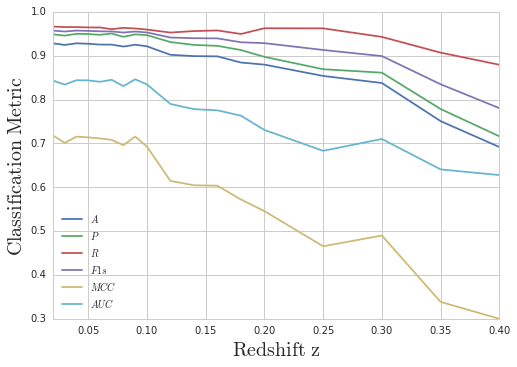

In [73]:
sns.set_style("whitegrid")
plt.xlabel(r'$\rm Redshift \ z$', fontsize=20)
plt.ylabel(r'$\rm Classification \ Metric$', fontsize=20)
plt.plot(redshifts[:18], As, label=r'$A$')
plt.plot(redshifts[:18], Ps, label=r'$P$')
plt.plot(redshifts[:18], Rs, label=r'$R$')
plt.plot(redshifts[:18], F1s, label=r'$F1s$')
plt.plot(redshifts[:18], MCCs, label=r'$MCC$')
plt.plot(redshifts[:18], AUCs, label=r'$AUC$')
plt.xlim([0.02, 0.40])
plt.legend(loc=3)
plt.savefig('/data/metrics.png', dpi=400)

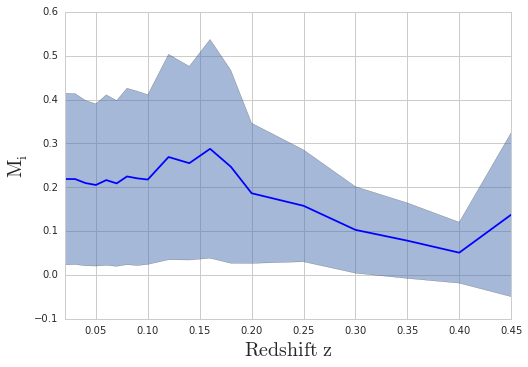

In [55]:
f, ax = plt.subplots(1, 1)
ax.plot(np.array(redshifts).astype(float), fits[0].T[:19], '-', color='blue')
ax.fill_between(np.array(redshifts).astype(float), fits[0].T[:19] - fits[1].T[:19], fits[0].T[:19] + fits[1].T[:19], alpha=0.5)
plt.xlim(0.02, 0.45)
plt.xlabel(r'$\rm Redshift \ z$',  fontsize=20)
plt.ylabel(r'$\rm M_i$', fontsize=20)